In [3]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [4]:
!unzip -qo bard.zip

In [5]:
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
!curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
!gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  840M  100  840M    0     0  25.8M      0  0:00:32  0:00:32 --:--:-- 27.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7500  100  7500    0     0  13466      0 --:--:-- --:--:-- --:--:-- 13489


In [4]:
!python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2025-11-30 07:34:45.887125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-30 07:34:45.887152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-30 07:34:45.888025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-30 07:34:45.892300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/xy/Desktop/ml/TF/legacy/lib/python3.10/site-pac

In [5]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

2025-11-30 07:34:55.698768: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-30 07:34:55.734061: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-30 07:34:55.734784: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক'])

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

In [7]:
dir_names = ['economy', 'sports', 'entertainment', 'state', 'international']

file_paths = []
labels = []
for i, dir in enumerate(dir_names):
  file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
  file_paths += file_names
  labels += [i] * len(os.listdir(dir))

np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

In [8]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

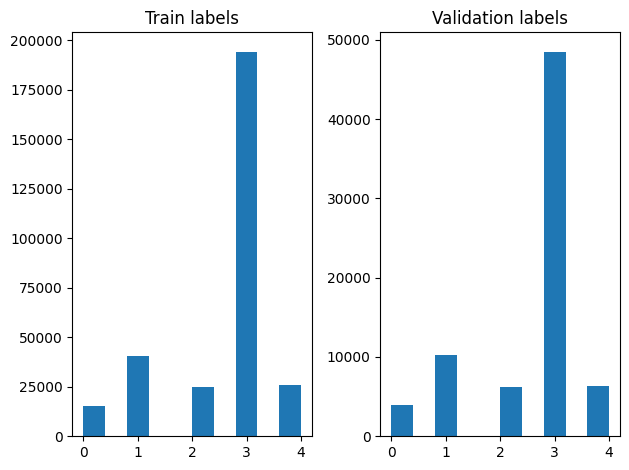

In [9]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

In [10]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [11]:
def make_datasets(train_size):
  batch_size = 256

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


  return train_ds, test_ds

In [12]:
train_data, validation_data = make_datasets(train_size)

In [13]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
  return model

In [14]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

In [15]:
history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[early_stopping_callback])

Epoch 1/5


2025-11-30 07:36:27.898073: I external/local_xla/xla/service/service.cc:168] XLA service 0x72f400e91840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-30 07:36:27.898095: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-30 07:36:27.916585: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-30 07:36:27.955595: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1764484588.015053   15951 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1176/1176 [==============================] - 17s 14ms/step - loss: 0.2319 - accuracy: 0.9232 - val_loss: 0.1529 - val_accuracy: 0.9485
Epoch 2/5
1176/1176 [==============================] - 16s 13ms/step - loss: 0.1436 - accuracy: 0.9498 - val_loss: 0.1367 - val_accuracy: 0.9529
Epoch 3/5
1176/1176 [==============================] - 16s 14ms/step - loss: 0.1318 - accuracy: 0.9532 - val_loss: 0.1273 - val_accuracy: 0.9545
Epoch 4/5
1176/1176 [==============================] - 15s 13ms/step - loss: 0.1237 - accuracy: 0.9554 - val_loss: 0.1235 - val_accuracy: 0.9560
Epoch 5/5
1176/1176 [==============================] - 15s 13ms/step - loss: 0.1182 - accuracy: 0.9571 - val_loss: 0.1208 - val_accuracy: 0.9561


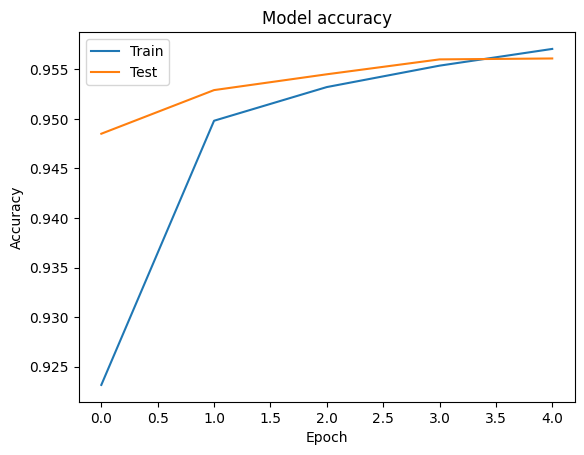

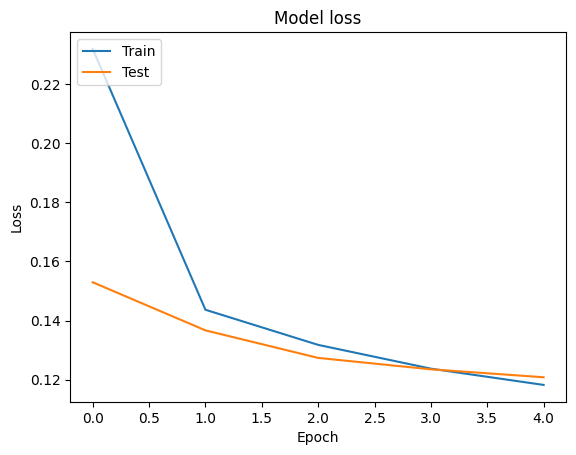

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
y_pred = model.predict(validation_data)

294/294 [==============================] - 3s 9ms/step


In [18]:
y_pred = np.argmax(y_pred, axis=1)

In [19]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ", sample.split("/")[0])
  print("Predicted Class: ", dir_names[y_pred[i]])
  f.close()


প্লাস্টিক সার্জারির পর বিগড়ে যাওয়া ঠোঁট নিয়ে অনেক বিরূপ মন্তব্য শুনতে হয়েছে আনুশকা শর্মাকে। এরপ
True Class:  entertainment
Predicted Class:  state

লোকসংগীতে গুরুত্বপূর্ণ অবদানের জন্য একুশে পদকে ভূষিত হওয়ায় রাম কানাই দাশকে অভিনন্দন জানিয়েছে সিলেটে
True Class:  state
Predicted Class:  state

বাংলাদেশের ব্রাজিল-সমর্থকদের জন্য সুখবর। তবে দুঃসংবাদ আর্জেন্টিনা সমর্থকদের জন্য। আজ টিভিতে ব্রাজিল
True Class:  sports
Predicted Class:  state


In [20]:
y_true = np.array(labels[train_size:])

In [21]:
print(classification_report(y_true, y_pred, target_names=dir_names))

               precision    recall  f1-score   support

      economy       0.82      0.73      0.77      3897
       sports       0.99      0.98      0.98     10204
entertainment       0.91      0.94      0.92      6256
        state       0.97      0.98      0.97     48512
international       0.95      0.92      0.93      6377

     accuracy                           0.96     75246
    macro avg       0.93      0.91      0.92     75246
 weighted avg       0.96      0.96      0.96     75246

